# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
ROUND = 2 # This project will have 3 rounds of predictions: 1,2,3
PATH_TO_DOWNLOADED = '/content/drive/My Drive/CS412_Project_Data/'
STUDENT_ID = '26754'
PROJECT_CODE = 'CS41201b6a44e6aa7' # Same code for the annotation eg. CS412xxxxx

In [6]:
cd /content/drive/My Drive/CS412_Project_Data/

/content/drive/My Drive/CS412_Project_Data


## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [7]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv('training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingAnnotTweetDf = pd.read_csv('annotated_tweets_CS412cebda9f52acd.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingAnnotTweetDf = trainingAnnotTweetDf.drop(columns=['sentiment', 'isExperiential', 'isInsult', 'url'])
trainingTweetDf = pd.concat([trainingTweetDf, trainingAnnotTweetDf], axis=0)


trainingAnnotTweetDf = pd.read_csv('annotated_tweets_CS412739093b76306.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingAnnotTweetDf = trainingAnnotTweetDf.drop(columns=['sentiment', 'isExperiential', 'isInsult', 'url'])
trainingTweetDf = pd.concat([trainingTweetDf, trainingAnnotTweetDf], axis=0)


trainingAnnotTweetDf = pd.read_csv('annotated_tweets_CS41201b6a44e6aa7.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingAnnotTweetDf = trainingAnnotTweetDf.drop(columns=['sentiment', 'isExperiential', 'isInsult', 'url'])
trainingTweetDf = pd.concat([trainingTweetDf, trainingAnnotTweetDf], axis=0)

# trainingAnnotTweetDf = pd.read_csv('annotated_tweets_CS41248c0785b082f.csv', dtype={'tweet_id': str, 'isPolitical': str})
# trainingAnnotTweetDf = trainingAnnotTweetDf.drop(columns=['sentiment', 'isExperiential', 'isInsult', 'url'])
#trainingTweetDf = pd.concat([trainingTweetDf, trainingAnnotTweetDf], axis=0)

#trainingTweetDf.drop_duplicates(subset=['tweet_id'], keep='first',inplace=True)


trainingTweetDf

,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
245,1380835983055273986,No
246,1367010396482207745,No
247,1440802825609510917,No
248,1425545850814619659,Yes


In [8]:
trainingTweetDf.isPolitical.value_counts()

No     1942
Yes    1807
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [9]:
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv('training-user.csv')
trainingAnnotUsersDf = pd.read_csv('annotated_users_CS412cebda9f52acd.csv')
trainingAnnotUsersDf = trainingAnnotUsersDf.drop(columns=['isOrganizational', 'isTroll', 'url'])
trainingUserDf = pd.concat([trainingUserDf, trainingAnnotUsersDf], axis=0)



trainingAnnotUsersDf = pd.read_csv('annotated_users_CS412739093b76306.csv')
trainingAnnotUsersDf = trainingAnnotUsersDf.drop(columns=['isOrganizational', 'isTroll', 'url'])
trainingUserDf = pd.concat([trainingUserDf, trainingAnnotUsersDf], axis=0)


trainingAnnotUsersDf = pd.read_csv('annotated_users_CS41201b6a44e6aa7.csv')
trainingAnnotUsersDf = trainingAnnotUsersDf.drop(columns=['isOrganizational', 'isTroll', 'url'])
trainingUserDf = pd.concat([trainingUserDf, trainingAnnotUsersDf], axis=0)


#trainingAnnotUsersDf = pd.read_csv('annotated_users_CS41248c0785b082f.csv')
#trainingAnnotUsersDf = trainingAnnotUsersDf.drop(columns=['isOrganizational', 'isTroll', 'url'])


#trainingUserDf.drop_duplicates(subset=['screen_name'], keep='first', inplace=True)

trainingUserDf.shape

(3750, 3)

In [10]:
trainingUserDf.isBot.value_counts()

No          2938
Yes          522
Not sure     290
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [11]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/AnnotationTwitterTR/reports/report_CS41201b6a44e6aa7.html


## 1. Landing Page

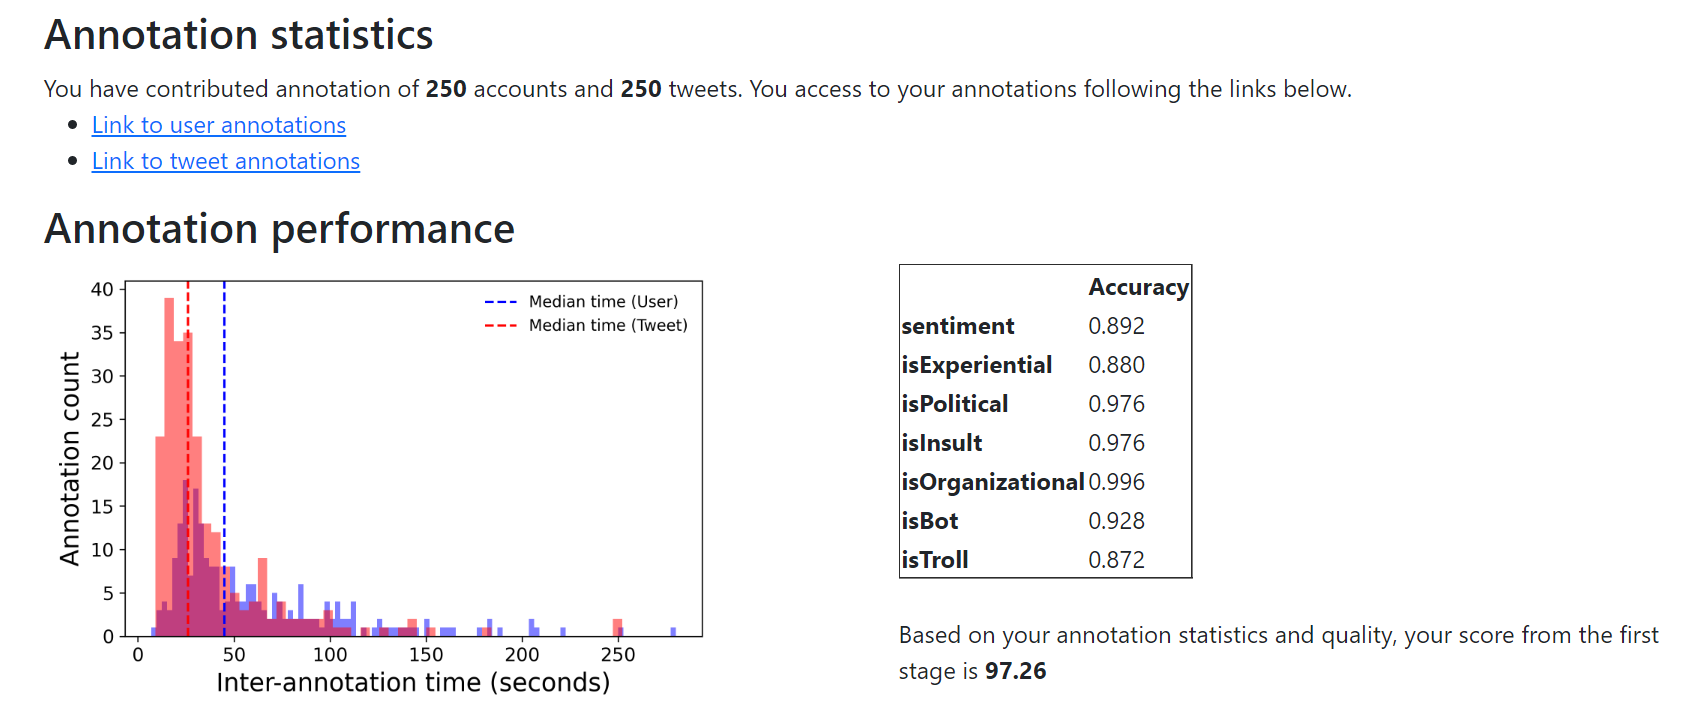

In [12]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

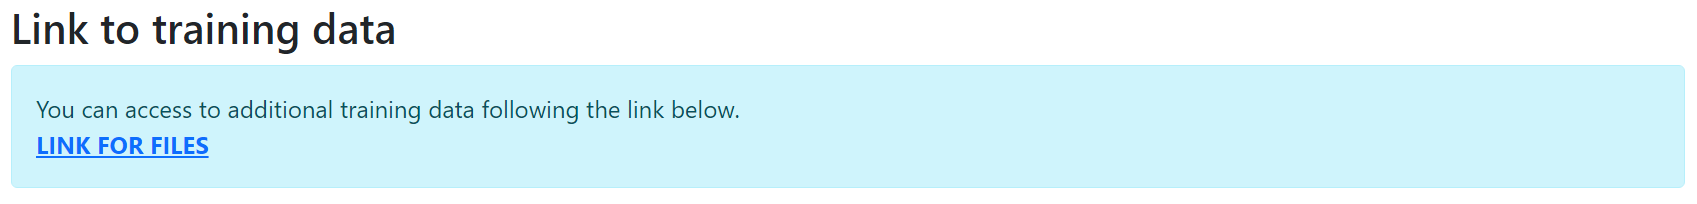

In [13]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

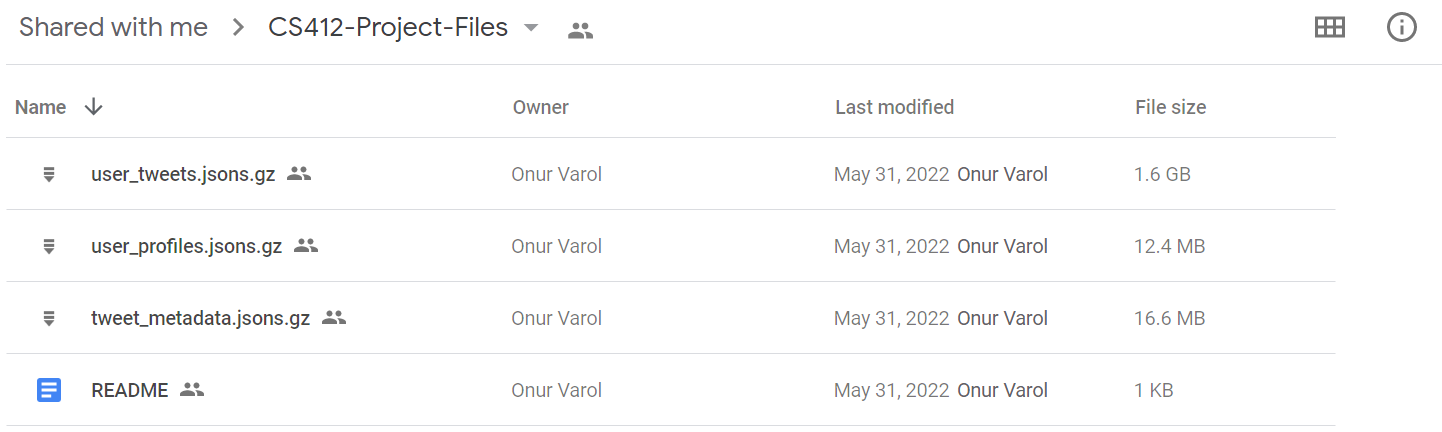

In [14]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [15]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [16]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [17]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [18]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [19]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [20]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [21]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'RTE', 'MevlutCavusoglu', 'umitozdag', 'Ümit Özdağ'
                        'Recep Tayyip Erdoğan', 'Recep Tayyip Erdogan', 'Süleyman Soylu', 'Ekrem İmamoğlu', 'Ekrem imamoğlu', 'ekrem_imamoglu',
                        'suleymansoylu', 'Ak parti', 'iyi parti', 'AKP', 'CHP', 'Akparti', 'Reis', 'drfahrettinkoca', 'melihgokcek', 
                        'devletbahceli', 'Bahçeli', 'Tayyip', 'Seçim', 'atama', "kyk", "Vuk359", 'eyt', "tcbestepe", "Sayın", "Meral Akşener", 
                        "Cumhurbaşkanımız", 'bay kemal', 'bekir bozdağ', 'bybekirbozdag', 'devlet', 'politik', 'meclis']
  
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [22]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [23]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
              'total_interactions':[]}


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)

        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)


        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)

In [24]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0
1,1445677417150889986,1,ekrem_imamoglu,RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...,1,0,6706,0,1263130166961864705,hasanak11633015,64 Jahre alt,1,6706
2,1456638729620230149,1,yenisafak,RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...,1,0,1545,0,2958652582,buyukdogu58,Katılıyorum: RT+FAV,1,1545
3,1451295314074341381,1,ekrem_imamoglu,RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...,1,0,7470,0,1447285927471112194,gskaya444,,1,7470
4,1440610747134844929,1,umitozdag,RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...,1,0,745,0,379944275,cerenncan,,2,745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,1439639972177489926,1,deryayanikashb,RT @deryayanikashb: AK Parti Çanakkale İl Başk...,1,0,48,0,165689533,sezayicimen,İst.Aydın Üniversitesi Mahalli İdareler ve Yer...,1,48
32998,1467519965473423362,1,kilicdarogluk,RT @kilicdarogluk: Türkiye Barolar Birliği 36....,1,0,4438,0,408719429,sdiplen1,Hepimiz birileri için kurallarımızı çiğnedik,2,4438
32999,1423666826282668035,1,rterdogan,RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...,1,0,14311,0,1004379711890485248,soguzsoylu,AK Parti Yumurtalık İlçe Başkanı,2,14311
33000,1417025303894007810,1,thetubaca,RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...,3,0,16,0,1049663929348222985,mhmt_ckmk04,667 ile yılları çalınan gurebadan bir garip...,0,16


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [25]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [26]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [27]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [28]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [29]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450
...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [30]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.1. Check Tweet Number Perday

In [31]:
def tweet_number_perday(line) :
  dict = {}
  for i in range(len(line['tweets'])) :
    arr = line['tweets'][i]['created_at'].split(' ')
    day = arr[1] + ' ' + arr[2] + ' ' + arr[5]
    if day in dict:
      dict[day] += 1
    else :
      dict[day] = 0
  
  sum = 0
  for key in dict :
    sum += dict[key]
  if(len(dict) == 0 ) :
    return 0

  #return(max(dict.values()))
  return sum/len(dict)

#### 1.2.2.2. Check median number of favorites

In [32]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

#### 1.2.2.3. Check median number of hashtags

In [33]:
def get_median_number_hashtags(line):
    num_median_hashtags = np.median([len(tweet['entities']['hashtags']) for tweet in line['tweets']])

    return num_median_hashtags

#### 1.2.2.4. Check median number of user_mentions

In [34]:
def get_median_number_user_mentions(line):
    num_median_user_mentions = np.median([len(tweet['entities']['user_mentions']) for tweet in line['tweets']])

    return num_median_user_mentions

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [35]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
               'tweet_number_perday_avg': [],
               }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        dfBotTweets['num_of_tweets'].append(len(line['tweets']))

        tweet_perday_avg = tweet_number_perday(line)
        dfBotTweets['tweet_number_perday_avg'].append(tweet_perday_avg)
  

        i += 1
        
        if i % 10000 == 0:
            print(i)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000


In [36]:
dfBotTweets = pd.DataFrame.from_dict(dfBotTweets, orient='index')

In [37]:
dfBotTweets = dfBotTweets.transpose()

### 1.2.3. Merge dfBot and dfBotTweets

In [38]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites', 'tweet_number_perday_avg']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites', 'tweet_number_perday_avg']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,num_of_tweets,tweet_number_perday_avg
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060,1.0,200,1.631579
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.200,107.0,200,0.315789
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0.230,1.0,200,1.941176
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0.000,0.0,NaN,0.000000
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,1.000,0.0,200,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0.735,0.0,200,4.714286
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0.020,1.0,200,2.333333
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0.000,24.0,200,0.869159
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0.000,76.5,200,19.000000


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [161]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,isPolitical
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
1,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
2,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
3,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,No
4,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,1471184915047895044,0,None,@Ayse_439617 @AilebakEkders @ABEPDERNEK @derya...,5,0,1,0,1361730369112973313,a439617,,2,1,Yes
3746,1447868445173899264,0,None,@YK06091 Bizlerde bu başarı belgelerine talibi...,0,0,0,1,1436208094657318912,yusuf_yaliniz,,1,1,Yes
3747,1417903713746882572,0,None,@birogrenci177 @turkcedusunuyor @drfahrettinko...,3,0,0,1,1230846507395538947,burakkrtw,“Herkesi dinlerim ama kendi doğru bildiğimi ya...,1,1,Yes
3748,1359654986087620608,0,None,@sercan_zorbozan Rabbim yardimcilari olsun,0,0,0,0,553934347,qilloali,Düsman oklari nereyi vuruyorsa bize orasi mevz...,0,0,No


In [162]:
from collections import Counter
dfPolitical_isPolitic = dfPoliticalAll_train[dfPoliticalAll_train["isPolitical"] == "No"]
print(dfPolitical_isPolitic.shape)
Counter(" ".join(dfPolitical_isPolitic["text"]).split()).most_common(50)

(1942, 14)


[('bir', 130),
 ('RT', 126),
 ('bu', 119),
 ('ve', 108),
 ('çok', 87),
 ('de', 82),
 ('ne', 66),
 ('için', 64),
 ('da', 61),
 ('ama', 54),
 ('ya', 53),
 ('ben', 53),
 ('var', 52),
 ('olsun', 42),
 ('o', 42),
 ('Bu', 42),
 ('daha', 40),
 ('@RTErdogan', 39),
 ('gibi', 37),
 ('ki', 37),
 ('bi', 37),
 ('kadar', 36),
 ('@drfahrettinkoca', 34),
 ('mi', 34),
 ('ile', 32),
 ('Allah', 31),
 ('yok', 31),
 ('her', 27),
 ('iyi', 26),
 ('diye', 26),
 ('öyle', 25),
 ('Günaydın', 24),
 ('hiç', 24),
 ('güzel', 23),
 ('mı', 23),
 ('en', 23),
 ('olan', 22),
 ('Bir', 22),
 ('Ben', 22),
 ('bile', 22),
 ('Ne', 22),
 ('seni', 22),
 ('benim', 21),
 ('şey', 20),
 ('değil', 19),
 ('sonra', 19),
 ('gün', 18),
 ('önce', 18),
 ('1', 18),
 ('olur', 18)]

In [163]:
from collections import Counter
dfPolitical_isPolitic = dfPoliticalAll_train[dfPoliticalAll_train["isPolitical"] == "Yes"]
print(dfPolitical_isPolitic.shape)
Counter(" ".join(dfPolitical_isPolitic["text"]).split()).most_common(50)

(1807, 14)


[('RT', 849),
 ('@RTErdogan', 297),
 ('ve', 279),
 ('bir', 195),
 ('bu', 124),
 ('@RTErdogan:', 123),
 ('için', 98),
 ('Sayın', 87),
 ('Cumhurbaşkanımız', 86),
 ('@drfahrettinkoca', 85),
 ('ile', 85),
 ('de', 82),
 ('Bu', 77),
 ('@kilicdarogluk', 63),
 ('@tcbestepe', 63),
 ('Cumhurbaşkanı', 62),
 ('da', 57),
 ('ne', 53),
 ('Tayyip', 51),
 ('daha', 48),
 ('Genel', 48),
 ('@dbdevletbahceli', 48),
 ('olarak', 48),
 ('Recep', 45),
 ('@suleymansoylu', 44),
 ('atama', 44),
 ('olan', 41),
 ('Başkanı', 40),
 ('@Akparti', 39),
 ('en', 39),
 ('@06melihgokcek:', 39),
 ('çok', 38),
 ('Bir', 38),
 ('Devlet', 38),
 ('gibi', 37),
 ('Kemal', 37),
 ('@meral_aksener', 36),
 ('Sn.', 36),
 ('Meral', 36),
 ('@tcsavunma', 36),
 ('@Akparti:', 34),
 ('kadar', 34),
 ('@ekrem_imamoglu', 34),
 ('değil', 34),
 ('artık', 32),
 ('Başkanımız', 30),
 ('@bekirpakdemirli', 29),
 ('var', 29),
 ('ama', 29),
 ('yok', 28)]

### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [164]:
from sklearn.preprocessing import MinMaxScaler

# scale the features between 0-1
msc = MinMaxScaler(feature_range=(0, 1))

scaled = msc.fit_transform(dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags']])

scaled_df = pd.DataFrame(scaled, columns=['num_political_entities','total_interactions','num_hashtags'])

In [167]:
X = scaled_df
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

### 2.1.3. Train - validation split

In [168]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtc_political = DecisionTreeClassifier()

# fit your model
dtc_political.fit(X_train, y_train)

# make predictions
preds = dtc_political.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.22 
 Accuracy Score: 0.78 
 Confusion Matrix: 
 [[521  68]
 [ 86  25]]


In [50]:
import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [170]:
nodes=[25, 50, 100]
learning_rates=[0.001, 0.01, 0.1]
activation=["sigmoid", "relu"]
models_politic=[]
models_politic_history=[]
model_politic_scores=[]
model_politic_scores_parameters=[]

In [171]:
def two_hidden_layer_model(nodes1, nodes2, learning_rate, activation):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(nodes1, activation=activation, input_shape=(X_train.shape[1],), name='hidden_1'))
  model.add(Dense(nodes2, activation=activation, name='hidden_2'))
  model.add(Dense(1, name='output_layer'))

  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
  models_politic_history.append(model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, shuffle=True))
  model_politic_scores.append(model.evaluate(X_valid, y_valid, verbose=0))
  model_politic_scores_parameters.append([nodes1, nodes2, learning_rate, activation])
  return model

In [172]:
for i in range(len(nodes)):
  for j in range(len(nodes)):
    for j in range(len(learning_rates)):
      for m in range(len(activation)):
        models_politic.append(two_hidden_layer_model(nodes[i], nodes[j], learning_rates[j], activation[m]))

Epoch 1/30
47/47 [==============================] - 1s 2ms/step - loss: 0.2460
Epoch 2/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2436
Epoch 3/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 4/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2370
Epoch 5/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2335
Epoch 6/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2322
Epoch 7/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2258
Epoch 8/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2216
Epoch 9/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2161
Epoch 10/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2115
Epoch 11/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2056
Epoch 12/30
47/47 [==============================] - 0s 2ms/step - loss: 0.2015
Epoch 13/30
47/47 [==============================

In [175]:
# tests on validation
max_model_politic_score_twoLayer = 1
max_model_politic_score_twoLayer_idx = 0

for i in range(len(model_politic_scores)):
  if model_politic_scores[i] < max_model_politic_score_twoLayer:
    max_model_politic_score_twoLayer = model_politic_scores[i]
    max_model_politic_score_twoLayer_idx = i


print("\nTWO HIDDEN LAYER: \n")
print("Min mean squared error is: ", max_model_politic_score_twoLayer)
print("Min mean squared error index: ", max_model_politic_score_twoLayer_idx)
print("Min mean squared error history: ", model_politic_scores_parameters[max_model_politic_score_twoLayer_idx])


TWO HIDDEN LAYER: 

Min mean squared error is:  0.1455920934677124
Min mean squared error index:  3
Min mean squared error history:  [25, 50, 0.01, 'relu']


In [ ]:
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[3,5,7,9,11]} 

grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search = grid.fit(X_train, y_train)
predictions_dtc = grid_search.predict(X_valid)

acc_score_dtc = accuracy_score(y_valid, predictions_dtc)
confusion_matrix_dtc = confusion_matrix(y_valid, predictions_dtc)
mse_dtc = mean_squared_error(y_valid, predictions_dtc)

f1Score_dtc = f1_score(y_valid, predictions_dtc, average='macro')

print("Mean Squared Error:", mse_dtc, "\n", "Accuracy Score:", acc_score_dtc, "\n", "Confusion Matrix:", "\n", confusion_matrix_dtc)
print(f1Score_dtc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Squared Error: 0.19066666666666668 
 Accuracy Score: 0.8093333333333333 
 Confusion Matrix: 
 [[342  39]
 [104 265]]
0.8073022130150511


In [ ]:
XGBC = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

grid_search_XGBC = GridSearchCV(
    estimator=XGBC,
    param_grid={
    'max_depth': range (2, 10, 1),
    'n_estimators': range(200, 600, 200),
    'learning_rate': [0.1, 0.01, 0.001, 0.0001]
},
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    return_train_score=False, 
    verbose=1, 
    refit=True)

grid_search_XGBC_political = grid_search_XGBC.fit(X_train, y_train)

predictions_XGBC = grid_search_XGBC_political.predict(X_valid)


acc_score_XGBC = accuracy_score(y_valid, predictions_XGBC)
confusion_matrix_XGBC = confusion_matrix(y_valid, predictions_XGBC)
mse_XGBC = mean_squared_error(y_valid, predictions_XGBC)

f1Score_XGBC = f1_score(y_valid, predictions_XGBC, average='macro')

print("Mean Squared Error:", mse_XGBC, "\n","Accuracy Score:", acc_score_XGBC, "\n","Confusion Matrix:", "\n", confusion_matrix_XGBC)

print(f1Score_XGBC)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Mean Squared Error: 0.17866666666666667 
 Accuracy Score: 0.8213333333333334 
 Confusion Matrix: 
 [[340  41]
 [ 93 276]]
0.8200227792064527


In [ ]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [10,20,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[3,5,7,9,11],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search_rfc_political = grid.fit(X_train, y_train)

predictions_rfc = grid_search_rfc_political.predict(X_valid)

acc_score_rfc = accuracy_score(y_valid, predictions_rfc)
confusion_rfc = confusion_matrix(y_valid, predictions_rfc)
mse_rfc = mean_squared_error(y_valid, predictions_rfc)

f1Score = f1_score(y_valid, predictions_rfc, average='macro')

print("Mean Squared Error::", mse_rfc, "\n", "Accuracy Score:", acc_score_rfc, "\n", "Confusion Matrix:", "\n", confusion_rfc)
print(f1Score)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mean Squared Error:: 0.176 
 Accuracy Score: 0.824 
 Confusion Matrix: 
 [[329  52]
 [ 80 289]]
0.8234979497236584


In [ ]:
logr = LogisticRegression(random_state=0)
logr.fit(X_train,y_train)

predictions_linear = logr.predict(X_valid)

acc_score_linear = accuracy_score(y_valid, predictions_linear)
confusion_matrix_linear = confusion_matrix(y_valid, predictions_linear)
mse_linear = mean_squared_error(y_valid, predictions_linear)

f1Score_linear = f1_score(y_valid, predictions_linear, average='macro')

print("Mean Squared Error::", mse_linear, "\n","Accuracy Score:", acc_score_linear, "\n","Confusion Matrix:", "\n", confusion_matrix_linear)

print(f1Score_linear)

Mean Squared Error:: 0.19466666666666665 
 Accuracy Score: 0.8053333333333333 
 Confusion Matrix: 
 [[342  39]
 [107 262]]
0.8030929688904873


In [ ]:
knn = KNeighborsClassifier()
#knn.fit(X_train,y_train)

param_grid = {'n_neighbors':[3,5,7,9,11]} 
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search_knn_political = grid.fit(X_train, y_train)

predictions_knn = grid_search_knn_political.predict(X_valid)

acc_score_knn = accuracy_score(y_valid, predictions_knn)
confusion_matrix_knn = confusion_matrix(y_valid, predictions_knn)
mse_knn = mean_squared_error(y_valid, predictions_knn)


f1Score_knn = f1_score(y_valid, predictions_knn, average='macro')

print("Mean Squared Error::", mse_knn, "\n","Accuracy Score:", acc_score_knn, "\n", "Confusion Matrix:", "\n", confusion_matrix_knn)

print(f1Score_knn)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Squared Error:: 0.18533333333333332 
 Accuracy Score: 0.8146666666666667 
 Confusion Matrix: 
 [[325  56]
 [ 83 286]]
0.8141641665730802


In [ ]:
gnb = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
grid = GridSearchCV(gnb,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search_gnb_political = grid.fit(X_train, y_train)
predictions_nbc = grid_search_gnb_political.predict(X_valid)

acc_score_nbc = accuracy_score(y_valid, predictions_nbc)
confusion_matrix_nbc = confusion_matrix(y_valid, predictions_nbc)
mse_nbc = mean_squared_error(y_valid, predictions_nbc)

f1Score_nbc = f1_score(y_valid, predictions_nbc, average='macro')

print("Mean Squared Error::", mse_nbc, "\n", "Accuracy Score:", acc_score_nbc, "\n", "Confusion Matrix:", "\n", confusion_matrix_nbc)

print(f1Score_nbc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean Squared Error:: 0.2866666666666667 
 Accuracy Score: 0.7133333333333334 
 Confusion Matrix: 
 [[367  14]
 [201 168]]
0.6916230476631242


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [40]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [41]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,num_of_tweets,tweet_number_perday_avg,screen_name,isBot,user_name
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,200,1.631579,grslsntlarogrt,Not sure,NaN
1,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,200,1.631579,grslsntlarogrt,Not sure,NaN
2,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.200000,107.0,200,0.315789,adnantoprak46,No,NaN
3,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.200000,107.0,200,0.315789,adnantoprak46,No,NaN
4,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0.230000,1.0,200,1.941176,oykunejla,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,1338444706204835840,laito proof,vtaeskit,eu ar55 childe main,namjoon yalvaririm telefonlarimi ac,270,673,35,0.286320,0.050000,1.0,200,7.000000,vtaeskit,No,NaN
3495,323513738,Ezgobar,shaammone,İzmir,humanoid 🏉 🏳️‍🌈,521,330,15,0.612221,0.025000,1.0,200,0.904762,shaammone,No,NaN
3496,1451270540669378572,Havva Sert,havvasert19,,,155,199,0,0.437853,0.835052,0.0,194,2.803922,havvasert19,No,NaN
3497,1354034188815654912,airi,airilynx,♡🧷she/her 18,#mitski ; i start the day high and it ends so ...,712,585,82,0.548959,0.120000,1.0,200,2.508772,airilynx,No,NaN


In [42]:
trainingUserDf.isBot.value_counts()

No          2938
Yes          522
Not sure     290
Name: isBot, dtype: int64

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [145]:
from sklearn.preprocessing import MinMaxScaler

# scale the features between 0-1
msc = MinMaxScaler(feature_range=(0, 1))

scaled = msc.fit_transform(dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites', 'tweet_number_perday_avg']])

scaled_df = pd.DataFrame(scaled, columns=['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites', 'tweet_number_perday_avg'])

In [146]:
X = scaled_df
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

### 2.2.3. Train-test split

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

In [148]:
nodes=[25, 50, 100]
learning_rates=[0.001, 0.01]
activation=["relu"]
models_bot=[]
models_bot_history=[]
model_bot_scores=[]
model_bot_scores_parameters=[]

In [149]:
def two_hidden_layer_model(nodes1, nodes2, learning_rate, activation):
  model = Sequential()
  model.add(Dense(nodes1, activation=activation, input_shape=(X_train.shape[1],), name='hidden_1'))
  model.add(Dense(nodes2, activation=activation, name='hidden_2'))
  model.add(Dense(1, name='output_layer'))

  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
  models_bot_history.append(model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, shuffle=True))
  model_bot_scores.append(model.evaluate(X_valid, y_valid, verbose=0))
  model_bot_scores_parameters.append([nodes1, nodes2, learning_rate, activation])
  return model

In [150]:
for i in range(len(nodes)):
  for j in range(len(nodes)):
    for k in range(len(learning_rates)):
      for m in range(len(activation)):
        models_bot.append(two_hidden_layer_model(nodes[i], nodes[j], learning_rates[k], activation[m]))

Epoch 1/30
44/44 [==============================] - 1s 2ms/step - loss: 0.1113
Epoch 2/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1035
Epoch 3/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1023
Epoch 4/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1020
Epoch 5/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1016
Epoch 6/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1014
Epoch 7/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 8/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 9/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1015
Epoch 10/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1010
Epoch 11/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1008
Epoch 12/30
44/44 [==============================] - 0s 2ms/step - loss: 0.1010
Epoch 13/30
44/44 [==============================

In [152]:
# tests on validation
max_model_bot_score_twoLayer = 1
max_model_bot_score_twoLayer_idx = 0

for i in range(len(model_bot_scores)):
  if model_bot_scores[i] < max_model_bot_score_twoLayer:
    max_model_bot_score_twoLayer = model_bot_scores[i]
    max_model_bot_score_twoLayer_idx = i


print("\nTWO HIDDEN LAYER: \n")
print("Min mean squared error is: ", max_model_bot_score_twoLayer)
print("Min mean squared error index: ", max_model_bot_score_twoLayer_idx)
print("Min mean squared error history: ", model_bot_scores_parameters[max_model_bot_score_twoLayer_idx])


TWO HIDDEN LAYER: 

Min mean squared error is:  0.11282903701066971
Min mean squared error index:  1
Min mean squared error history:  [25, 25, 0.01, 'relu']


In [ ]:
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[3,5,7,9,11]} 

grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search = grid.fit(X_train, y_train)
predictions_dtc = grid_search.predict(X_valid)

acc_score_dtc = accuracy_score(y_valid, predictions_dtc)
confusion_matrix_dtc = confusion_matrix(y_valid, predictions_dtc)
mse_dtc = mean_squared_error(y_valid, predictions_dtc)

f1Score_dtc = f1_score(y_valid, predictions_dtc, average='macro')

print("Mean Squared Error:", mse_dtc, "\n", "Accuracy Score:", acc_score_dtc, "\n", "Confusion Matrix:", "\n", confusion_matrix_dtc)
print(f1Score_dtc)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Squared Error: 0.18 
 Accuracy Score: 0.82 
 Confusion Matrix: 
 [[554  35]
 [ 91  20]]
0.569428443107926


In [ ]:
XGBC = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

grid_search_XGBC = GridSearchCV(
    estimator=XGBC,
    param_grid={
    'max_depth': range (2, 10, 1),
    'n_estimators': range(200, 600, 200),
    'learning_rate': [0.1, 0.01, 0.001]
},
    scoring = 'f1',
    n_jobs = 10,
    cv = 5,
    return_train_score=False, 
    verbose=1, 
    refit=True)

grid_search_XGBC_bot = grid_search_XGBC.fit(X_train, y_train)

predictions_XGBC = grid_search_XGBC_bot.predict(X_valid)


acc_score_XGBC = accuracy_score(y_valid, predictions_XGBC)
confusion_matrix_XGBC = confusion_matrix(y_valid, predictions_XGBC)
mse_XGBC = mean_squared_error(y_valid, predictions_XGBC)

f1Score_XGBC = f1_score(y_valid, predictions_XGBC, average='macro')

print("Mean Squared Error:", mse_XGBC, "\n","Accuracy Score:", acc_score_XGBC, "\n","Confusion Matrix:", "\n", confusion_matrix_XGBC)

print(f1Score_XGBC)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mean Squared Error: 0.16714285714285715 
 Accuracy Score: 0.8328571428571429 
 Confusion Matrix: 
 [[573  16]
 [101  10]]
0.5266744109437037


In [ ]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [10,20,50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[3,5,7,9,11],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search_rfc_bot = grid.fit(X_train, y_train)

predictions_rfc = grid_search_rfc_bot.predict(X_valid)

acc_score_rfc = accuracy_score(y_valid, predictions_rfc)
confusion_rfc = confusion_matrix(y_valid, predictions_rfc)
mse_rfc = mean_squared_error(y_valid, predictions_rfc)

f1Score = f1_score(y_valid, predictions_rfc, average='macro')

print("Mean Squared Error::", mse_rfc, "\n", "Accuracy Score:", acc_score_rfc, "\n", "Confusion Matrix:", "\n", confusion_rfc)
print(f1Score)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mean Squared Error:: 0.15571428571428572 
 Accuracy Score: 0.8442857142857143 
 Confusion Matrix: 
 [[583   6]
 [103   8]]
0.5212549019607844


In [ ]:
predictions_rfc = grid_search_rfc_bot.predict(X_valid)

acc_score_rfc = accuracy_score(y_valid, predictions_rfc)
confusion_rfc = confusion_matrix(y_valid, predictions_rfc)
mse_rfc = mean_squared_error(y_valid, predictions_rfc)

f1Score = f1_score(y_valid, predictions_rfc, average='macro')

print("Mean Squared Error::", mse_rfc, "\n", "Accuracy Score:", acc_score_rfc, "\n", "Confusion Matrix:", "\n", confusion_rfc)
print(f1Score)

Mean Squared Error:: 0.15571428571428572 
 Accuracy Score: 0.8442857142857143 
 Confusion Matrix: 
 [[583   6]
 [103   8]]
0.5212549019607844


In [ ]:
logr_bot = LogisticRegression(random_state=0)
logr_bot.fit(X_train,y_train)

predictions_linear = logr_bot.predict(X_valid)

acc_score_linear = accuracy_score(y_valid, predictions_linear)
confusion_matrix_linear = confusion_matrix(y_valid, predictions_linear)
mse_linear = mean_squared_error(y_valid, predictions_linear)

f1Score_linear = f1_score(y_valid, predictions_linear, average='macro')

print("Mean Squared Error::", mse_linear, "\n","Accuracy Score:", acc_score_linear, "\n","Confusion Matrix:", "\n", confusion_matrix_linear)

print(f1Score_linear)

Mean Squared Error:: 0.15285714285714286 
 Accuracy Score: 0.8471428571428572 
 Confusion Matrix: 
 [[587   2]
 [105   6]]
0.5086559213849474


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [181]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('evaluation-round2-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags']]

msc = MinMaxScaler(feature_range=(0, 1))
X = msc.fit_transform(X)

# make predictions based on these variables
predictions_political = models_politic[max_model_politic_score_twoLayer_idx].predict(X)

### This part is important! We expect you to return your predictions in the following format:

In [182]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.22999173402786255,
 '1446578802507780102': 0.23372496664524078,
 '1396859026705629191': 0.23111170530319214,
 '1351058108651630593': 0.2303650677204132,
 '1344910889741393920': 0.22999173402786255,
 '1402216638926163968': 0.7295825481414795,
 '1433340600544342016': 0.22999173402786255,
 '1359234185819541505': 0.2303650677204132,
 '1370134257490870273': 0.22999173402786255,
 '1404914095254654985': 0.22999173402786255,
 '1423390250932518912': 0.7987987995147705,
 '1379103391561973776': 0.22999173402786255,
 '1441887862262321152': 0.3211398124694824,
 '1428477576436125697': 0.2303650677204132,
 '1430964534865547267': 0.2303650677204132,
 '1396099692392591369': 0.22999173402786255,
 '1453457844834025482': 0.7987987995147705,
 '1368522336543137795': 0.23297834396362305,
 '1471136747916562432': 0.8976922035217285,
 '1426676740659814403': 0.22999173402786255,
 '1380989833452093440': 0.22999173402786255,
 '1382055945849729026': 0.22999173402786255,
 '13862201682931015

## 3.2. Predictions for Users (Bot or Not)

In [157]:
evaluationUserDf = pd.read_csv('evaluation-round2-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites',  'tweet_number_perday_avg']]

# from sklearn.preprocessing import MinMaxScaler

msc = MinMaxScaler(feature_range=(0, 1))
X = msc.fit_transform(X)

# make predictions based on these variables
predictions_bot = models_bot[max_model_bot_score_twoLayer_idx].predict(X)

In [158]:
#compare = (lambda y1, y2: y1 if y1 > y2 else y2)

#modelPredUser = dict([(x, compare(y[0], y[1])) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])

modelPredUser = dict([(x, float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.05795338749885559,
 'oykunejla': 0.09001690149307251,
 'ay3613': 0.08544892072677612,
 'hazanguzel': 0.05531403794884682,
 'sabirsiztr': 0.05219564214348793,
 'alonedrummer': 0.11316804587841034,
 'doktoramaaktor': 0.07890541106462479,
 'canimmbenimm3': 0.17631088197231293,
 'muneccimsimge': 0.0571950227022171,
 'gsbgenclikspor': 0.10742025077342987,
 'koramzeynep': 0.05278918892145157,
 'rabosscy': 0.05464969202876091,
 'aykut190720': 0.13879644870758057,
 'shadowoflower': 0.06910137832164764,
 'adler16392917': 0.07672122120857239,
 'alioztoprak06': 0.05615644529461861,
 'taylankumelii': 0.053216882050037384,
 'ozk_emrullah': 0.07987698912620544,
 'emineemiir': 0.10732093453407288,
 'rsrsrs97': 0.05278473347425461,
 'herseyeloji': 0.15899845957756042,
 'eceemsoysal': 0.05316716060042381,
 'prfbaris': 0.05757078528404236,
 'emell_zaim': 0.05181942135095596,
 'seminanurrk': 0.052326980978250504,
 'viennabjk93': 0.07576541602611542,
 'neogaymyback': 0.0535046532750129

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [184]:
with open('{}/{}-round{}-tweet.txt'.format(PATH_TO_DOWNLOADED, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))

In [185]:
with open('{}/{}-round{}-user.txt'.format(PATH_TO_DOWNLOADED, STUDENT_ID, ROUND), 'w') as fl:
     fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
     fl.write(json.dumps(modelPredUser))

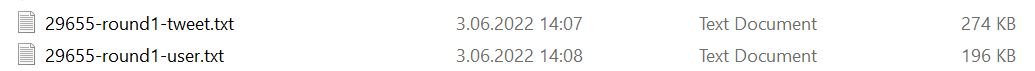

In [ ]:
display.Image("https://i.imgur.com/lcwRsOW.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


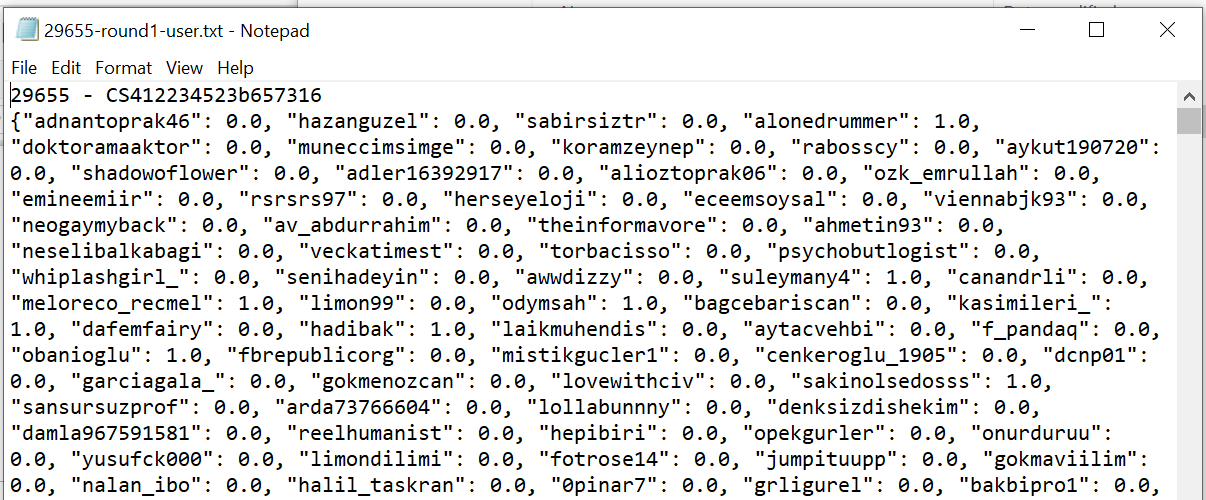

In [ ]:
display.Image("https://i.imgur.com/qfxqgMF.png")

You can check whether you can read your predictions correctly or not:

In [189]:
with open('{}/{}-round{}-tweet.txt'.format(PATH_TO_DOWNLOADED, STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])